<a href="https://colab.research.google.com/github/jakenowo/G14_Project/blob/main/G14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSC 522 Project - Group 14**

Note: [alldata.csv](https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us) needs to be uploaded to the session before running the code.

In [2]:
# Import and/or download all required libraries

# Math, data, and plotting
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

!pip install spacy
!python -m spacy download en_core_web_sm
import spacy

!pip install contractions
import contractions

# Clustering
!pip install kmodes
from kmodes.kmodes import KModes

# Classification models for feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Read "alldata.csv" dataset from session data (see note at top)
df_original = pd.read_csv('/content/alldata.csv', engine='python', error_bad_lines=False)
df_original.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [4]:
# Initial info about dataset
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     6953 non-null   object 
 1   company      6953 non-null   object 
 2   description  6953 non-null   object 
 3   reviews      5326 non-null   float64
 4   location     6953 non-null   object 
dtypes: float64(1), object(4)
memory usage: 272.2+ KB


In [5]:
# Drop "reviews" attribute
df_original['reviews'].isnull().values.sum()
df = df_original.drop(['reviews'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   position     6953 non-null   object
 1   company      6953 non-null   object
 2   description  6953 non-null   object
 3   location     6953 non-null   object
dtypes: object(4)
memory usage: 217.8+ KB


In [6]:
# Count null values
df.isnull().sum()

position       11
company        11
description    11
location       11
dtype: int64

In [7]:
# Drop null values
df.dropna()

,position,company,description,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...","Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...","Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,"Atlanta, GA"
...,...,...,...,...
6959,Data Developer / Machine Learning Analyst,NetApp,Are you data-driven? We at NetApp believe in t...,"Sunnyvale, CA"
6960,Scientist I,"Pharmacyclics, an Abbvie Company",Pharmacyclics is committed to the development ...,"Sunnyvale, CA"
6961,Intern Scientist,Oath Inc,"Oath, a subsidiary of Verizon, is a values-led...","Sunnyvale, CA"
6962,Senior Data & Applied Scientist,Microsoft,We are the Bing Core Relevance team responsibl...,"Sunnyvale, CA"


In [8]:
# Randomly sample some titles
position_df = df['position']
position_df = position_df.to_frame()

position_df.sample(10, random_state = 5)

,position
5636,Principal Scientist
1499,"Software Engineer, Data Visualization"
6761,Computer Vision Scientist/Engineer
5720,SDE III - Bits | Twitch
2433,Market Research Analyst
5948,Sr. Data Engineer
2157,Technology Consultant
5840,Data Scientist (All Levels)
51,"Director, Data Scientist"
1393,Data Scientist


In [9]:
# Split title strings and reassemble contractions
position_df['pos'] = position_df['position'].astype(str).str.split()
position_df['pos'] = position_df['pos'].apply(lambda x: [contractions.fix(word) for word in x])
print(position_df.shape)
position_df.sample(10, random_state = 5)

(6964, 2)


,position,pos
5636,Principal Scientist,"[Principal, Scientist]"
1499,"Software Engineer, Data Visualization","[Software, Engineer,, Data, Visualization]"
6761,Computer Vision Scientist/Engineer,"[Computer, Vision, Scientist/Engineer]"
5720,SDE III - Bits | Twitch,"[SDE, III, -, Bits, |, Twitch]"
2433,Market Research Analyst,"[Market, Research, Analyst]"
5948,Sr. Data Engineer,"[Sr., Data, Engineer]"
2157,Technology Consultant,"[Technology, Consultant]"
5840,Data Scientist (All Levels),"[Data, Scientist, (All, Levels)]"
51,"Director, Data Scientist","[Director,, Data, Scientist]"
1393,Data Scientist,"[Data, Scientist]"


In [10]:
# Combine split strings
position_df['pos_str'] = [' '.join(map(str, l)) for l in position_df['pos']]
position_df.sample(10, random_state = 5)

,position,pos,pos_str
5636,Principal Scientist,"[Principal, Scientist]",Principal Scientist
1499,"Software Engineer, Data Visualization","[Software, Engineer,, Data, Visualization]","Software Engineer, Data Visualization"
6761,Computer Vision Scientist/Engineer,"[Computer, Vision, Scientist/Engineer]",Computer Vision Scientist/Engineer
5720,SDE III - Bits | Twitch,"[SDE, III, -, Bits, |, Twitch]",SDE III - Bits | Twitch
2433,Market Research Analyst,"[Market, Research, Analyst]",Market Research Analyst
5948,Sr. Data Engineer,"[Sr., Data, Engineer]",Sr. Data Engineer
2157,Technology Consultant,"[Technology, Consultant]",Technology Consultant
5840,Data Scientist (All Levels),"[Data, Scientist, (All, Levels)]",Data Scientist (All Levels)
51,"Director, Data Scientist","[Director,, Data, Scientist]","Director, Data Scientist"
1393,Data Scientist,"[Data, Scientist]",Data Scientist


In [11]:
# Use regular expression to remove unwanted punctuation
position_df['re_pos'] = position_df['pos_str'].apply(lambda x: re.sub(r'[^\w\d\s\'\,\.\;]+', ' ', x))

position_df.sample(10, random_state = 5)

,position,pos,pos_str,re_pos
5636,Principal Scientist,"[Principal, Scientist]",Principal Scientist,Principal Scientist
1499,"Software Engineer, Data Visualization","[Software, Engineer,, Data, Visualization]","Software Engineer, Data Visualization","Software Engineer, Data Visualization"
6761,Computer Vision Scientist/Engineer,"[Computer, Vision, Scientist/Engineer]",Computer Vision Scientist/Engineer,Computer Vision Scientist Engineer
5720,SDE III - Bits | Twitch,"[SDE, III, -, Bits, |, Twitch]",SDE III - Bits | Twitch,SDE III Bits Twitch
2433,Market Research Analyst,"[Market, Research, Analyst]",Market Research Analyst,Market Research Analyst
5948,Sr. Data Engineer,"[Sr., Data, Engineer]",Sr. Data Engineer,Sr. Data Engineer
2157,Technology Consultant,"[Technology, Consultant]",Technology Consultant,Technology Consultant
5840,Data Scientist (All Levels),"[Data, Scientist, (All, Levels)]",Data Scientist (All Levels),Data Scientist All Levels
51,"Director, Data Scientist","[Director,, Data, Scientist]","Director, Data Scientist","Director, Data Scientist"
1393,Data Scientist,"[Data, Scientist]",Data Scientist,Data Scientist


In [12]:
# Tokenize title strings
position_df['tokenized_title'] = position_df['re_pos'].apply(word_tokenize)
position_df.sample(10, random_state = 5)

,position,pos,pos_str,re_pos,tokenized_title
5636,Principal Scientist,"[Principal, Scientist]",Principal Scientist,Principal Scientist,"[Principal, Scientist]"
1499,"Software Engineer, Data Visualization","[Software, Engineer,, Data, Visualization]","Software Engineer, Data Visualization","Software Engineer, Data Visualization","[Software, Engineer, ,, Data, Visualization]"
6761,Computer Vision Scientist/Engineer,"[Computer, Vision, Scientist/Engineer]",Computer Vision Scientist/Engineer,Computer Vision Scientist Engineer,"[Computer, Vision, Scientist, Engineer]"
5720,SDE III - Bits | Twitch,"[SDE, III, -, Bits, |, Twitch]",SDE III - Bits | Twitch,SDE III Bits Twitch,"[SDE, III, Bits, Twitch]"
2433,Market Research Analyst,"[Market, Research, Analyst]",Market Research Analyst,Market Research Analyst,"[Market, Research, Analyst]"
5948,Sr. Data Engineer,"[Sr., Data, Engineer]",Sr. Data Engineer,Sr. Data Engineer,"[Sr., Data, Engineer]"
2157,Technology Consultant,"[Technology, Consultant]",Technology Consultant,Technology Consultant,"[Technology, Consultant]"
5840,Data Scientist (All Levels),"[Data, Scientist, (All, Levels)]",Data Scientist (All Levels),Data Scientist All Levels,"[Data, Scientist, All, Levels]"
51,"Director, Data Scientist","[Director,, Data, Scientist]","Director, Data Scientist","Director, Data Scientist","[Director, ,, Data, Scientist]"
1393,Data Scientist,"[Data, Scientist]",Data Scientist,Data Scientist,"[Data, Scientist]"


In [13]:
# Download and get set of stopwords from nltk package
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Remove stopwords and recombine tokenized titles
position_df['tokenized_title'] = position_df['tokenized_title'].apply(lambda x: [word for word in x if word not in stop_words])
position_df['tokenized_title_join'] = [' '.join(map(str, l)) for l in position_df['tokenized_title']]

position_df.sample(10, random_state = 5)

,position,pos,pos_str,re_pos,tokenized_title,tokenized_title_join
5636,Principal Scientist,"[Principal, Scientist]",Principal Scientist,Principal Scientist,"[Principal, Scientist]",Principal Scientist
1499,"Software Engineer, Data Visualization","[Software, Engineer,, Data, Visualization]","Software Engineer, Data Visualization","Software Engineer, Data Visualization","[Software, Engineer, ,, Data, Visualization]","Software Engineer , Data Visualization"
6761,Computer Vision Scientist/Engineer,"[Computer, Vision, Scientist/Engineer]",Computer Vision Scientist/Engineer,Computer Vision Scientist Engineer,"[Computer, Vision, Scientist, Engineer]",Computer Vision Scientist Engineer
5720,SDE III - Bits | Twitch,"[SDE, III, -, Bits, |, Twitch]",SDE III - Bits | Twitch,SDE III Bits Twitch,"[SDE, III, Bits, Twitch]",SDE III Bits Twitch
2433,Market Research Analyst,"[Market, Research, Analyst]",Market Research Analyst,Market Research Analyst,"[Market, Research, Analyst]",Market Research Analyst
5948,Sr. Data Engineer,"[Sr., Data, Engineer]",Sr. Data Engineer,Sr. Data Engineer,"[Sr., Data, Engineer]",Sr. Data Engineer
2157,Technology Consultant,"[Technology, Consultant]",Technology Consultant,Technology Consultant,"[Technology, Consultant]",Technology Consultant
5840,Data Scientist (All Levels),"[Data, Scientist, (All, Levels)]",Data Scientist (All Levels),Data Scientist All Levels,"[Data, Scientist, All, Levels]",Data Scientist All Levels
51,"Director, Data Scientist","[Director,, Data, Scientist]","Director, Data Scientist","Director, Data Scientist","[Director, ,, Data, Scientist]","Director , Data Scientist"
1393,Data Scientist,"[Data, Scientist]",Data Scientist,Data Scientist,"[Data, Scientist]",Data Scientist


In [15]:
# Load English to spacy
nlp = spacy.load('en_core_web_sm')
nlp

In [16]:
# Explore common noun chunks in titles
for sentence in position_df['tokenized_title_join'].sample(10, random_state = 4):
  print("Sentence is: ", sentence)
  sentence_doc = nlp(sentence)

  for chunk in sentence_doc.noun_chunks:
    print ("Chunked noun phrases found: ",chunk)
  print()

Sentence is:  Senior Clinical Project Assistant
Chunked noun phrases found:  Senior Clinical Project Assistant

Sentence is:  Senior Statistical Analyst
Chunked noun phrases found:  Senior Statistical Analyst

Sentence is:  Vice President , Data Science , Banking Wealth , US
Chunked noun phrases found:  Vice President
Chunked noun phrases found:  Data Science
Chunked noun phrases found:  Banking Wealth
Chunked noun phrases found:  US

Sentence is:  Senior Sales Account Executive
Chunked noun phrases found:  Senior Sales Account Executive

Sentence is:  Associate PHC Data Scientist PHC Data Scientist Analytics
Chunked noun phrases found:  Associate PHC Data Scientist PHC Data Scientist Analytics

Sentence is:  Research Data Analyst Senior Statistician
Chunked noun phrases found:  Research Data Analyst Senior Statistician

Sentence is:  Principal Data Scientist
Chunked noun phrases found:  Principal Data Scientist

Sentence is:  Data Scientist GEOINT
Chunked noun phrases found:  Data Sci

# **Cleaning and Tokenizing Descriptions**

In [17]:
# Get set of stop words
stop_words = set(stopwords.words('english'))

In [18]:
# Get descriptions from dataset
descriptions = df['description']
descriptions

0       Development Director\nALS Therapy Development ...
1       Job Description\n\n"The road that leads to acc...
2       Growing company located in the Atlanta, GA are...
3       DEPARTMENT: Program OperationsPOSITION LOCATIO...
4       DESCRIPTION\nThe Emory University Department o...
                              ...                        
6959    Are you data-driven? We at NetApp believe in t...
6960    Pharmacyclics is committed to the development ...
6961    Oath, a subsidiary of Verizon, is a values-led...
6962    We are the Bing Core Relevance team responsibl...
6963    Comcast’s Technology &amp; Product organizatio...
Name: description, Length: 6964, dtype: object

In [19]:
# Turn into dataframe
desc_df = df['description'].to_frame()

# Add new column with descriptions in lowercase
desc_df['lower'] = df['description'].str.lower()
desc_df.sample(10, random_state = 5)

,description,lower
5636,I: Job\n\nContributes to the strategic directi...,i: job\n\ncontributes to the strategic directi...
1499,"About our teams:\nAt Tempus, products are owne...","about our teams:\nat tempus, products are owne..."
6761,"Baidu USA, located in Silicon Valley, is looki...","baidu usa, located in silicon valley, is looki..."
5720,Job Description\n\n\nTwitch is building the fu...,job description\n\n\ntwitch is building the fu...
2433,We are seeking qualified Analysts to join our ...,we are seeking qualified analysts to join our ...
5948,We’re LendingHome. We’re on a mission to revol...,we’re lendinghome. we’re on a mission to revol...
2157,Who We Are\nBusiness has changed - so should c...,who we are\nbusiness has changed - so should c...
5840,Finding a good job is very good.\nFinding a go...,finding a good job is very good.\nfinding a go...
51,Innovate. Collaborate. Shine. Lighthouse — KPM...,innovate. collaborate. shine. lighthouse — kpm...
1393,"What We Do\n\nAt Uptake, our purpose-built pro...","what we do\n\nat uptake, our purpose-built pro..."


In [20]:
# Split strings and reassemble contractions
desc_df['pos'] = desc_df['lower'].astype(str).str.split()
desc_df['pos'] = desc_df['pos'].apply(lambda x: [contractions.fix(word) for word in x])
desc_df.sample(10, random_state = 5)

,description,lower,pos
5636,I: Job\n\nContributes to the strategic directi...,i: job\n\ncontributes to the strategic directi...,"[i:, job, contributes, to, the, strategic, dir..."
1499,"About our teams:\nAt Tempus, products are owne...","about our teams:\nat tempus, products are owne...","[about, our, teams:, at, tempus,, products, ar..."
6761,"Baidu USA, located in Silicon Valley, is looki...","baidu usa, located in silicon valley, is looki...","[baidu, usa,, located, in, silicon, valley,, i..."
5720,Job Description\n\n\nTwitch is building the fu...,job description\n\n\ntwitch is building the fu...,"[job, description, twitch, is, building, the, ..."
2433,We are seeking qualified Analysts to join our ...,we are seeking qualified analysts to join our ...,"[we, are, seeking, qualified, analysts, to, jo..."
5948,We’re LendingHome. We’re on a mission to revol...,we’re lendinghome. we’re on a mission to revol...,"[we are, lendinghome., we are, on, a, mission,..."
2157,Who We Are\nBusiness has changed - so should c...,who we are\nbusiness has changed - so should c...,"[who, we, are, business, has, changed, -, so, ..."
5840,Finding a good job is very good.\nFinding a go...,finding a good job is very good.\nfinding a go...,"[finding, a, good, job, is, very, good., findi..."
51,Innovate. Collaborate. Shine. Lighthouse — KPM...,innovate. collaborate. shine. lighthouse — kpm...,"[innovate., collaborate., shine., lighthouse, ..."
1393,"What We Do\n\nAt Uptake, our purpose-built pro...","what we do\n\nat uptake, our purpose-built pro...","[what, we, do, at, uptake,, our, purpose-built..."


In [21]:
# Combine split strings
desc_df['pos_str'] = [' '.join(map(str, l)) for l in desc_df['pos']]
desc_df.sample(10, random_state = 5)

,description,lower,pos,pos_str
5636,I: Job\n\nContributes to the strategic directi...,i: job\n\ncontributes to the strategic directi...,"[i:, job, contributes, to, the, strategic, dir...",i: job contributes to the strategic direction ...
1499,"About our teams:\nAt Tempus, products are owne...","about our teams:\nat tempus, products are owne...","[about, our, teams:, at, tempus,, products, ar...","about our teams: at tempus, products are owned..."
6761,"Baidu USA, located in Silicon Valley, is looki...","baidu usa, located in silicon valley, is looki...","[baidu, usa,, located, in, silicon, valley,, i...","baidu usa, located in silicon valley, is looki..."
5720,Job Description\n\n\nTwitch is building the fu...,job description\n\n\ntwitch is building the fu...,"[job, description, twitch, is, building, the, ...",job description twitch is building the future ...
2433,We are seeking qualified Analysts to join our ...,we are seeking qualified analysts to join our ...,"[we, are, seeking, qualified, analysts, to, jo...",we are seeking qualified analysts to join our ...
5948,We’re LendingHome. We’re on a mission to revol...,we’re lendinghome. we’re on a mission to revol...,"[we are, lendinghome., we are, on, a, mission,...",we are lendinghome. we are on a mission to rev...
2157,Who We Are\nBusiness has changed - so should c...,who we are\nbusiness has changed - so should c...,"[who, we, are, business, has, changed, -, so, ...",who we are business has changed - so should co...
5840,Finding a good job is very good.\nFinding a go...,finding a good job is very good.\nfinding a go...,"[finding, a, good, job, is, very, good., findi...",finding a good job is very good. finding a goo...
51,Innovate. Collaborate. Shine. Lighthouse — KPM...,innovate. collaborate. shine. lighthouse — kpm...,"[innovate., collaborate., shine., lighthouse, ...",innovate. collaborate. shine. lighthouse — kpm...
1393,"What We Do\n\nAt Uptake, our purpose-built pro...","what we do\n\nat uptake, our purpose-built pro...","[what, we, do, at, uptake,, our, purpose-built...","what we do at uptake, our purpose-built produc..."


In [22]:
# Use regular expression to remove punctuation
desc_df['cleaner'] = desc_df['pos_str'].apply(lambda x: re.sub(r'[^\w\d\s\'\,\.\;]+', ' ', x))
desc_df.sample(10, random_state = 5)

,description,lower,pos,pos_str,cleaner
5636,I: Job\n\nContributes to the strategic directi...,i: job\n\ncontributes to the strategic directi...,"[i:, job, contributes, to, the, strategic, dir...",i: job contributes to the strategic direction ...,i job contributes to the strategic direction ...
1499,"About our teams:\nAt Tempus, products are owne...","about our teams:\nat tempus, products are owne...","[about, our, teams:, at, tempus,, products, ar...","about our teams: at tempus, products are owned...","about our teams at tempus, products are owned..."
6761,"Baidu USA, located in Silicon Valley, is looki...","baidu usa, located in silicon valley, is looki...","[baidu, usa,, located, in, silicon, valley,, i...","baidu usa, located in silicon valley, is looki...","baidu usa, located in silicon valley, is looki..."
5720,Job Description\n\n\nTwitch is building the fu...,job description\n\n\ntwitch is building the fu...,"[job, description, twitch, is, building, the, ...",job description twitch is building the future ...,job description twitch is building the future ...
2433,We are seeking qualified Analysts to join our ...,we are seeking qualified analysts to join our ...,"[we, are, seeking, qualified, analysts, to, jo...",we are seeking qualified analysts to join our ...,we are seeking qualified analysts to join our ...
5948,We’re LendingHome. We’re on a mission to revol...,we’re lendinghome. we’re on a mission to revol...,"[we are, lendinghome., we are, on, a, mission,...",we are lendinghome. we are on a mission to rev...,we are lendinghome. we are on a mission to rev...
2157,Who We Are\nBusiness has changed - so should c...,who we are\nbusiness has changed - so should c...,"[who, we, are, business, has, changed, -, so, ...",who we are business has changed - so should co...,who we are business has changed so should co...
5840,Finding a good job is very good.\nFinding a go...,finding a good job is very good.\nfinding a go...,"[finding, a, good, job, is, very, good., findi...",finding a good job is very good. finding a goo...,finding a good job is very good. finding a goo...
51,Innovate. Collaborate. Shine. Lighthouse — KPM...,innovate. collaborate. shine. lighthouse — kpm...,"[innovate., collaborate., shine., lighthouse, ...",innovate. collaborate. shine. lighthouse — kpm...,innovate. collaborate. shine. lighthouse kpm...
1393,"What We Do\n\nAt Uptake, our purpose-built pro...","what we do\n\nat uptake, our purpose-built pro...","[what, we, do, at, uptake,, our, purpose-built...","what we do at uptake, our purpose-built produc...","what we do at uptake, our purpose built produc..."


In [23]:
# Tokenize
desc_df['tokenized'] = desc_df['cleaner'].apply(word_tokenize)

# Remove stopwords
desc_df['tokenized'] = desc_df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
desc_df.sample(10, random_state = 5)

,description,lower,pos,pos_str,cleaner,tokenized
5636,I: Job\n\nContributes to the strategic directi...,i: job\n\ncontributes to the strategic directi...,"[i:, job, contributes, to, the, strategic, dir...",i: job contributes to the strategic direction ...,i job contributes to the strategic direction ...,"[job, contributes, strategic, direction, proje..."
1499,"About our teams:\nAt Tempus, products are owne...","about our teams:\nat tempus, products are owne...","[about, our, teams:, at, tempus,, products, ar...","about our teams: at tempus, products are owned...","about our teams at tempus, products are owned...","[teams, tempus, ,, products, owned, developed,..."
6761,"Baidu USA, located in Silicon Valley, is looki...","baidu usa, located in silicon valley, is looki...","[baidu, usa,, located, in, silicon, valley,, i...","baidu usa, located in silicon valley, is looki...","baidu usa, located in silicon valley, is looki...","[baidu, usa, ,, located, silicon, valley, ,, l..."
5720,Job Description\n\n\nTwitch is building the fu...,job description\n\n\ntwitch is building the fu...,"[job, description, twitch, is, building, the, ...",job description twitch is building the future ...,job description twitch is building the future ...,"[job, description, twitch, building, future, i..."
2433,We are seeking qualified Analysts to join our ...,we are seeking qualified analysts to join our ...,"[we, are, seeking, qualified, analysts, to, jo...",we are seeking qualified analysts to join our ...,we are seeking qualified analysts to join our ...,"[seeking, qualified, analysts, join, team, ., ..."
5948,We’re LendingHome. We’re on a mission to revol...,we’re lendinghome. we’re on a mission to revol...,"[we are, lendinghome., we are, on, a, mission,...",we are lendinghome. we are on a mission to rev...,we are lendinghome. we are on a mission to rev...,"[lendinghome, ., mission, revolutionize, world..."
2157,Who We Are\nBusiness has changed - so should c...,who we are\nbusiness has changed - so should c...,"[who, we, are, business, has, changed, -, so, ...",who we are business has changed - so should co...,who we are business has changed so should co...,"[business, changed, consulting, ., strategists..."
5840,Finding a good job is very good.\nFinding a go...,finding a good job is very good.\nfinding a go...,"[finding, a, good, job, is, very, good., findi...",finding a good job is very good. finding a goo...,finding a good job is very good. finding a goo...,"[finding, good, job, good, ., finding, good, j..."
51,Innovate. Collaborate. Shine. Lighthouse — KPM...,innovate. collaborate. shine. lighthouse — kpm...,"[innovate., collaborate., shine., lighthouse, ...",innovate. collaborate. shine. lighthouse — kpm...,innovate. collaborate. shine. lighthouse kpm...,"[innovate, ., collaborate, ., shine, ., lighth..."
1393,"What We Do\n\nAt Uptake, our purpose-built pro...","what we do\n\nat uptake, our purpose-built pro...","[what, we, do, at, uptake,, our, purpose-built...","what we do at uptake, our purpose-built produc...","what we do at uptake, our purpose built produc...","[uptake, ,, purpose, built, products, ingest, ..."


# **Add Skill Features**

In [24]:
# List of skills we want to look for
skills = {'python', '.net', 'java', 'javascript', 'typescript', 'r', 'sql', 'c', 'scala', 'aws', 'azure', 'sas', 'hadoop', 'spark', 'ajax', 'css', 'html', 'tensorflow', 'docker', 'keras', 'caffe', 'excel', 'matlab', 'mongodb', 'pytorch', 'nosql', 'tableau', 'hive', 'git', 'postgresql', 'powershell', 'xml', 'ruby', 'mysql', 'ssh', 'dynamodb', 'haskell', 'splunk', 'xquery', 'oracle', 'swift', 'tomcat', 'postgis', 'julia', 'neo4j', 'rapidminer', 'qlikview', 'spss', 'stata', 'octave', 'cassandra', 'elasticsearch', 'hbase'}
skills

{'.net',
 'ajax',
 'aws',
 'azure',
 'c',
 'caffe',
 'cassandra',
 'css',
 'docker',
 'dynamodb',
 'elasticsearch',
 'excel',
 'git',
 'hadoop',
 'haskell',
 'hbase',
 'hive',
 'html',
 'java',
 'javascript',
 'julia',
 'keras',
 'matlab',
 'mongodb',
 'mysql',
 'neo4j',
 'nosql',
 'octave',
 'oracle',
 'postgis',
 'postgresql',
 'powershell',
 'python',
 'pytorch',
 'qlikview',
 'r',
 'rapidminer',
 'ruby',
 'sas',
 'scala',
 'spark',
 'splunk',
 'spss',
 'sql',
 'ssh',
 'stata',
 'swift',
 'tableau',
 'tensorflow',
 'tomcat',
 'typescript',
 'xml',
 'xquery'}

# **Feature Extraction**

In [25]:
# Build new dataframe with clean titles and description tokens
skills_df = pd.DataFrame({'title': position_df['tokenized_title_join'], 'desc_tokens': desc_df['tokenized']})

# Create new attribute for each skill. 1 if skill in description tokens, 0 otherwise
for skill in skills:
  skills_df[skill] = skills_df.apply(lambda x: int(skill in x['desc_tokens']), axis=1)

skills_df.sample(10, random_state = 5)

,title,desc_tokens,css,qlikview,html,scala,haskell,r,tensorflow,mysql,postgis,xml,elasticsearch,nosql,python,keras,cassandra,ruby,spark,caffe,ajax,postgresql,sas,java,hive,hadoop,rapidminer,typescript,stata,excel,xquery,octave,julia,mongodb,ssh,splunk,spss,aws,c,tableau,javascript,sql,tomcat,hbase,neo4j,git,.net,docker,powershell,pytorch,oracle,matlab,dynamodb,azure,swift
5636,Principal Scientist,"[job, contributes, strategic, direction, proje...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1499,"Software Engineer , Data Visualization","[teams, tempus, ,, products, owned, developed,...",0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6761,Computer Vision Scientist Engineer,"[baidu, usa, ,, located, silicon, valley, ,, l...",0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5720,SDE III Bits Twitch,"[job, description, twitch, building, future, i...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2433,Market Research Analyst,"[seeking, qualified, analysts, join, team, ., ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5948,Sr. Data Engineer,"[lendinghome, ., mission, revolutionize, world...",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2157,Technology Consultant,"[business, changed, consulting, ., strategists...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5840,Data Scientist All Levels,"[finding, good, job, good, ., finding, good, j...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
51,"Director , Data Scientist","[innovate, ., collaborate, ., shine, ., lighth...",0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1393,Data Scientist,"[uptake, ,, purpose, built, products, ingest, ...",0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0


In [26]:
# Remove entries that have none of the specified skills
skills_df = skills_df.loc[skills_df.sum(axis=1) > 0,]
skills_df.sample(10, random_state = 5)

,title,desc_tokens,css,qlikview,html,scala,haskell,r,tensorflow,mysql,postgis,xml,elasticsearch,nosql,python,keras,cassandra,ruby,spark,caffe,ajax,postgresql,sas,java,hive,hadoop,rapidminer,typescript,stata,excel,xquery,octave,julia,mongodb,ssh,splunk,spss,aws,c,tableau,javascript,sql,tomcat,hbase,neo4j,git,.net,docker,powershell,pytorch,oracle,matlab,dynamodb,azure,swift
42,Manager Data Scientist Orlando,"[manager, orlando, location, overview, data, s...",0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
5236,"Senior Manager , Biospecimen Operations IO","[locations, us, wa, seattle, dexter, ave., des...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5383,Software Dev Engineer II Full Stack,"[job, description, passionate, developing, sim...",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3048,Pharmacoepidemiologist,"[job, description, primary, role, gpe, pharmac...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6802,Senior Wireless Machine Learning Researcher,"[job, description, core, innovation, group, ca...",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4139,Senior Data Analyst,"[nyu, langone, health, world, class, ,, patien...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1488,Bioinformatics Scientist,"[passionate, making, difference, world, cancer...",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4762,Staff Software Engineer Architect,"[seeking, staff, software, desgn, engineer, ar...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
929,Computational Biologist,"[company, description, client, energetic, new,...",0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5142,"Senior Software Development Engineer , Pricing","[looking, grow, ,, meaningful, projects, ,, wo...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# Create dataframe containing only extracted features
encoded_skills = skills_df.copy().drop(columns=['title', 'desc_tokens'])
encoded_skills.head()

,css,qlikview,html,scala,haskell,r,tensorflow,mysql,postgis,xml,elasticsearch,nosql,python,keras,cassandra,ruby,spark,caffe,ajax,postgresql,sas,java,hive,hadoop,rapidminer,typescript,stata,excel,xquery,octave,julia,mongodb,ssh,splunk,spss,aws,c,tableau,javascript,sql,tomcat,hbase,neo4j,git,.net,docker,powershell,pytorch,oracle,matlab,dynamodb,azure,swift
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Number of Clusters Evaluation**

In [28]:
# New dataframe to hold k values (# of clusters) and average dissimilarities
k_dissim_df = pd.DataFrame()
k_dissim_df['k'] = [k for k in range(1, 15)]

In [ ]:
# NOTE: This cell takes about 15 minutes to run

# List of average dissimilarities for each k (# of clusters)
avg_dissims = []

for k in range(1, 15):
  print(f'Cluster size: {k}')

  # Create KModes for k clusters and 20 tries
  km_huang = KModes(n_clusters=k, init="Huang", n_init=10, verbose=0, random_state=25, n_jobs=-5)

  # Fit model using data
  huang_clusters = km_huang.fit_predict(encoded_skills)

  # Convert data to numpy array
  encoded_skills_np = encoded_skills.to_numpy()

  # Array of matching dissimilarities for each entry
  dissims = []

  # Compute matching dissimilarity between each entry and its centroid
  for i in range(0, len(huang_clusters)):
    entry = encoded_skills_np[i]
    cluster_num = huang_clusters[i]
    centroid = km_huang.cluster_centroids_[cluster_num]
    dissims.append(np.sum(entry != centroid, axis=0))

  # Append average dissimilarity to list
  avg_dissims.append(sum(dissims) / len(dissims))

k_dissim_df['avg_dissim'] = avg_dissims
k_dissim_df

Cluster size: 1
Cluster size: 2
Cluster size: 3
Cluster size: 4
Cluster size: 5
Cluster size: 6
Cluster size: 7
Cluster size: 8
Cluster size: 9
Cluster size: 10
Cluster size: 11
Cluster size: 12
Cluster size: 13
Cluster size: 14


,k,avg_dissim
0,1,3.957090
1,2,3.251866
2,3,3.015858
3,4,2.845149
4,5,2.745336
5,6,2.641791
6,7,2.571828
7,8,2.549440
8,9,2.421642
9,10,2.343284


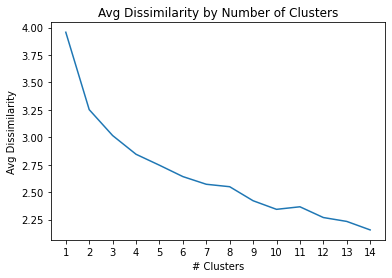

In [ ]:
# Plot for elbow method
plt.title('Avg Dissimilarity by Number of Clusters')
plt.xlabel('# Clusters', fontsize=10)
plt.ylabel('Avg Dissimilarity', fontsize=10)
plt.plot(k_dissim_df['k'], k_dissim_df['avg_dissim'])
plt.xticks(np.arange(1, 15, 1));

# **Clustering Skills**

In [34]:
# Create KModes model
n_clusters=5
km_huang = KModes(n_clusters=n_clusters, init="Huang", n_init=10, verbose=1, random_state=25)

In [38]:
# Fit model with extracted features
huang_clusters = km_huang.fit_predict(encoded_skills)
huang_clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2151, cost: 13006.0
Run 1, iteration: 2/100, moves: 491, cost: 13006.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1700, cost: 13793.0
Run 2, iteration: 2/100, moves: 0, cost: 13793.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 961, cost: 13570.0
Run 3, iteration: 2/100, moves: 476, cost: 13309.0
Run 3, iteration: 3/100, moves: 201, cost: 13309.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1252, cost: 14073.0
Run 4, iteration: 2/100, moves: 143, cost: 14073.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1567, cost: 12895.0
Run 5, iteration: 2/100, moves: 315, cost: 12895.0
Init: initializing centroids
Init: in

array([0, 1, 1, ..., 4, 4, 2], dtype=uint16)

In [39]:
# Count how many items are in each cluster
(unique, counts) = np.unique(huang_clusters, return_counts=True)
freqs = np.asarray((unique, counts)).T
freqs

array([[   0, 1373],
       [   1, 1646],
       [   2,  396],
       [   3,  742],
       [   4,  701]])

# **Skill Importance using RandomForest**

In [61]:
# Dataframe to store skills after they're ranked
ranked_skills = pd.DataFrame()

for cluster in range(5):
  # Create DataFrame column that identifies if an entry is in the cluster
  class_member_labels = pd.DataFrame()
  class_member_labels['in cluster'] = [int(x == cluster) for x in huang_clusters]

  # Split data into test and training data
  X_train, X_test, y_train, y_test = train_test_split(encoded_skills, class_member_labels, test_size=0.3, random_state=25)

  # Create a Random Forest Classifier model and fit to training data
  rfc = RandomForestClassifier(max_depth=10, random_state=25)
  rfc.fit(X_train, y_train['in cluster'].ravel())

  # Calculate permutation importance using test data and sort from highest to lowest
  imps = permutation_importance(rfc, X_test, y_test['in cluster'].ravel(), random_state=25)['importances_mean']
  skill_imps = pd.DataFrame({'skill':list(skills), 'importance':list(imps)}).sort_values('importance', ascending=False)
  
  # Store ranked skills in dataframe
  ranked_skills['Cluster ' + str(cluster)] = skill_imps['skill'].ravel()

# Display skills ranked for each cluster
ranked_skills

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,excel,python,scala,excel,c
1,python,r,spark,python,java
2,r,sql,hadoop,r,r
3,sql,java,java,sql,python
4,java,c,python,java,sql
5,c,scala,hive,spark,spark
6,scala,hadoop,sql,scala,excel
7,tableau,spark,r,ruby,hadoop
8,hive,spss,matlab,c,scala
9,hadoop,nosql,javascript,sas,javascript


In [63]:
RF_top_skills = ranked_skills[:10].values
RF_top_skills

array([['excel', 'python', 'scala', 'excel', 'c'],
       ['python', 'r', 'spark', 'python', 'java'],
       ['r', 'sql', 'hadoop', 'r', 'r'],
       ['sql', 'java', 'java', 'sql', 'python'],
       ['java', 'c', 'python', 'java', 'sql'],
       ['c', 'scala', 'hive', 'spark', 'spark'],
       ['scala', 'hadoop', 'sql', 'scala', 'excel'],
       ['tableau', 'spark', 'r', 'ruby', 'hadoop'],
       ['hive', 'spss', 'matlab', 'c', 'scala'],
       ['hadoop', 'nosql', 'javascript', 'sas', 'javascript']],
      dtype=object)

# **Skill Importance using Naive Bayes**

In [ ]:
class_member_labels = pd.DataFrame()
class_member_labels['c2'] = [int(x == 4) for x in huang_clusters]
X_train, X_test, y_train, y_test = train_test_split(encoded_skills, class_member_labels, test_size=0.3, random_state=25)
cnb = CategoricalNB()
cnb.fit(X_train, y_train)
imps = permutation_importance(cnb, X_test, y_test, random_state=25)
importances = imps.importances_mean

prob = pd.DataFrame({'cluster_4':list(importances),'skill':list(skills)})


cluster_2=prob.sort_values(by='cluster_4', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


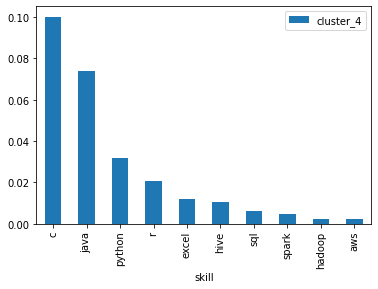

In [ ]:
cluster_10=cluster_2.iloc[0:10,:]
ax = cluster_10.plot.bar(x='skill',y='cluster_4')

In [70]:
# Dataframe to store skills after they're ranked
ranked_skills = pd.DataFrame()

for cluster in range(5):
  # Create DataFrame column that identifies if an entry is in the cluster
  class_member_labels = pd.DataFrame()
  class_member_labels['in cluster'] = [int(x == cluster) for x in huang_clusters]

  # Split data into test and training data
  X_train, X_test, y_train, y_test = train_test_split(encoded_skills, class_member_labels, test_size=0.3, random_state=25)

  # Create a Naive Bayes model and fit to training data
  cnb = CategoricalNB()
  cnb.fit(X_train, y_train['in cluster'].ravel())

  # Calculate permutation importance using test data and sort from highest to lowest
  imps = permutation_importance(rfc, X_test, y_test['in cluster'].ravel(), random_state=25)['importances_mean']
  skill_imps = pd.DataFrame({'skill':list(skills), 'importance':list(imps)}).sort_values('importance', ascending=False)
  
  # Store ranked skills in dataframe
  ranked_skills['Cluster ' + str(cluster)] = skill_imps['skill'].ravel()

# Display skills ranked for each cluster
ranked_skills

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,spark,spark,python,spark,c
1,r,python,r,r,java
2,scala,scala,elasticsearch,python,r
3,hadoop,hadoop,pytorch,scala,python
4,elasticsearch,elasticsearch,matlab,hadoop,sql
5,matlab,matlab,azure,matlab,spark
6,hbase,hbase,hbase,elasticsearch,excel
7,azure,azure,aws,aws,hadoop
8,aws,aws,spss,hbase,scala
9,tableau,spss,caffe,azure,javascript


In [80]:
NB_top_skills = ranked_skills[:10].values
NB_top_skills

array([['spark', 'spark', 'python', 'spark', 'c'],
       ['r', 'python', 'r', 'r', 'java'],
       ['scala', 'scala', 'elasticsearch', 'python', 'r'],
       ['hadoop', 'hadoop', 'pytorch', 'scala', 'python'],
       ['elasticsearch', 'elasticsearch', 'matlab', 'hadoop', 'sql'],
       ['matlab', 'matlab', 'azure', 'matlab', 'spark'],
       ['hbase', 'hbase', 'hbase', 'elasticsearch', 'excel'],
       ['azure', 'azure', 'aws', 'aws', 'hadoop'],
       ['aws', 'aws', 'spss', 'hbase', 'scala'],
       ['tableau', 'spss', 'caffe', 'azure', 'javascript']], dtype=object)

# **Skill Importance using Cluster Frequency**

In [66]:
# Dataframe to store most frequent skills
cluster_freq_skills = pd.DataFrame()

for i in range(5):
  # Sum frequencies and add to dataframe
  skill_freqs = skills_df[list(skills)][huang_clusters == i].sum().to_frame('freq').sort_values(by=['freq'], ascending=False)
  cluster_freq_skills['Cluster ' + str(i)] = skill_freqs.index

# Display most frequent skills for each cluster
cluster_freq_skills

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,r,python,spark,excel,python
1,python,r,python,sql,c
2,sql,sql,hadoop,r,java
3,c,sas,java,sas,javascript
4,spark,spark,scala,c,aws
5,aws,tableau,r,tableau,r
6,sas,hadoop,sql,spss,matlab
7,hadoop,matlab,hive,python,hadoop
8,matlab,java,c,matlab,scala
9,tensorflow,c,aws,oracle,spark


In [67]:
Freq_top_skills = cluster_freq_skills[:10].values
Freq_top_skills

array([['r', 'python', 'spark', 'excel', 'python'],
       ['python', 'r', 'python', 'sql', 'c'],
       ['sql', 'sql', 'hadoop', 'r', 'java'],
       ['c', 'sas', 'java', 'sas', 'javascript'],
       ['spark', 'spark', 'scala', 'c', 'aws'],
       ['aws', 'tableau', 'r', 'tableau', 'r'],
       ['sas', 'hadoop', 'sql', 'spss', 'matlab'],
       ['hadoop', 'matlab', 'hive', 'python', 'hadoop'],
       ['matlab', 'java', 'c', 'matlab', 'scala'],
       ['tensorflow', 'c', 'aws', 'oracle', 'spark']], dtype=object)

# **Comparative Analysis**

In [68]:
# Display same skills for each cluster between skill importance methods
for i in range(5):
  RF_temp = set(RF_top_skills[:, i])
  NB_temp = set(NB_top_skills[:, i])
  Freq_temp = set(Freq_top_skills[:, i])

  temp = Freq_temp.intersection(RF_temp)
  temp = temp.intersection(NB_temp)

  print('Cluster {}: {}'.format(i, temp))

Cluster 0: {'r', 'hadoop'}
Cluster 1: {'spark', 'hadoop', 'python'}
Cluster 2: {'r', 'python'}
Cluster 3: {'r', 'python'}
Cluster 4: {'hadoop', 'scala', 'spark', 'r', 'c', 'java', 'javascript', 'python'}


In [69]:
# Display different skills for each cluster between skill importance methods
for i in range(5):
  RF_temp = set(RF_top_skills[:, i])
  NB_temp = set(NB_top_skills[:, i])
  Freq_temp = set(Freq_top_skills[:, i])

  temp = Freq_temp.intersection(RF_temp)
  temp = temp.intersection(NB_temp)

  all_skills = RF_temp.union(NB_temp.union(Freq_temp))
  complement = all_skills ^ temp

  print('Cluster {}: {}'.format(i, complement))

Cluster 0: {'excel', 'python', 'aws', 'hive', 'scala', 'java', 'spark', 'matlab', 'tensorflow', 'sas', 'azure', 'c', 'tableau', 'elasticsearch', 'hbase', 'sql'}
Cluster 1: {'aws', 'sql', 'scala', 'azure', 'java', 'matlab', 'r', 'sas', 'spss', 'c', 'tableau', 'elasticsearch', 'hbase', 'nosql'}
Cluster 2: {'hive', 'pytorch', 'scala', 'azure', 'hbase', 'c', 'spark', 'caffe', 'matlab', 'java', 'spss', 'aws', 'elasticsearch', 'javascript', 'sql', 'hadoop'}
Cluster 3: {'excel', 'aws', 'ruby', 'oracle', 'scala', 'azure', 'java', 'spark', 'matlab', 'sas', 'spss', 'c', 'tableau', 'elasticsearch', 'hbase', 'sql', 'hadoop'}
Cluster 4: {'excel', 'matlab', 'aws', 'sql'}


# **Exploratory Analysis & Visualizations**

In [ ]:
# Assemble the frequencies of the skills collected
skills_freq = pd.DataFrame()
skills_freq['skills'] = list(skills)
skills_freq['freq'] = skills_df[list(skills)].sum().values
skills_freq = skills_freq.sort_values(by=['freq'], ascending=False)

skills_freq.transpose()

,42,43,19,52,12,33,50,28,16,39,2,48,9,24,15,20,29,14,1,0,51,22,47,32,13,21,4,44,37,46,17,41,27,7,35,5,38,18,40,3,10,8,34,6,49,36,26,31,45,11,25,30,23
skills,python,r,sql,c,java,excel,spark,hadoop,sas,aws,matlab,scala,tableau,hive,tensorflow,javascript,nosql,azure,git,oracle,spss,ruby,mysql,docker,stata,pytorch,keras,caffe,css,mongodb,cassandra,html,hbase,postgresql,elasticsearch,.net,xml,julia,qlikview,dynamodb,splunk,ajax,neo4j,powershell,typescript,swift,octave,haskell,rapidminer,tomcat,postgis,ssh,xquery
freq,2813,2126,1686,1249,1231,987,957,917,654,642,559,497,485,484,401,352,329,242,217,215,208,191,168,158,138,126,124,122,115,115,113,113,112,104,86,64,57,52,43,37,36,20,17,17,16,15,14,10,9,8,8,3,2


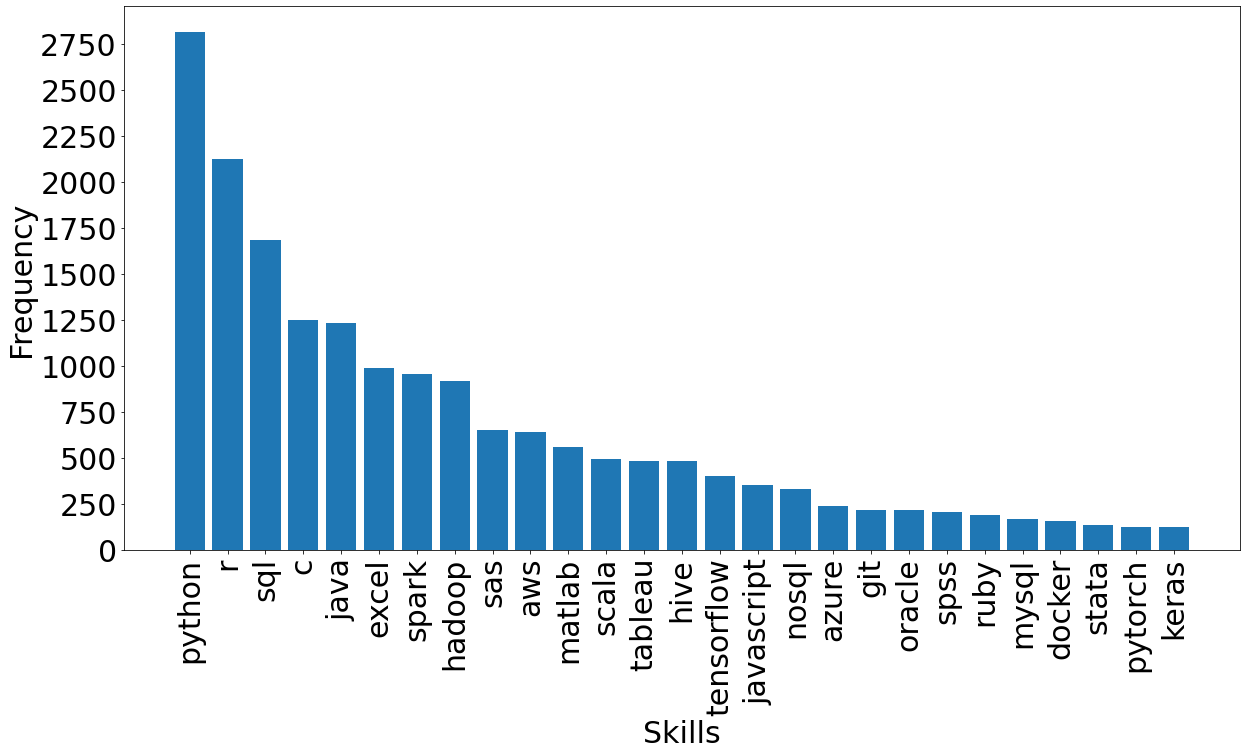

In [ ]:
# Display frequencies of the top 27 skills
n_skills = 27
plt.figure(figsize=(20, 10))
plt.bar(skills_freq.head(n_skills)['skills'], skills_freq.head(n_skills)['freq'])
plt.xlabel('Skills', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(skills_freq['skills'].head(n_skills), rotation='vertical', fontsize=30)
plt.yticks(np.arange(0, 3000, 250), fontsize=30);

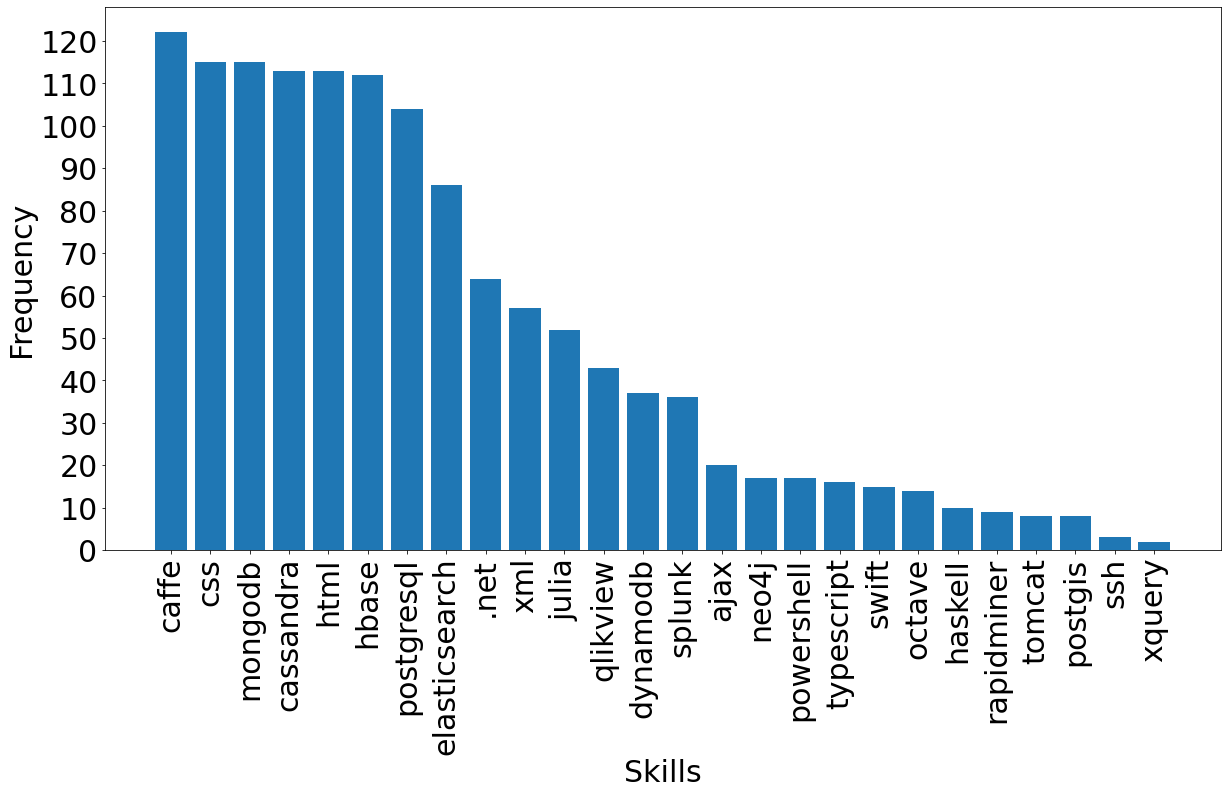

In [ ]:
# Display frequencies of the bottom 26 skills
n_skills = 26
plt.figure(figsize=(20, 10))
plt.bar(skills_freq.tail(n_skills)['skills'], skills_freq.tail(n_skills)['freq'])
plt.xlabel('Skills', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xticks(skills_freq['skills'].tail(n_skills), rotation='vertical', fontsize=30)
plt.yticks(np.arange(0, 130, 10), fontsize=30);

In [50]:
# Assemble distribution of the data from the 5 clusters
km_huang_vis = KModes(n_clusters=5, init="Huang", n_init=10, random_state=25)
huang_clusters_vis = km_huang_vis.fit_predict(encoded_skills)
freq_cluster = np.unique(huang_clusters_vis, return_counts=True)
freq_cluster

(array([0, 1, 2, 3, 4], dtype=uint16), array([1373, 1646,  396,  742,  701]))

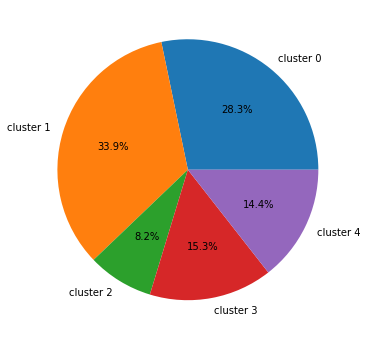

In [51]:
# Display distribution of the data among the clusters
freq_cluster = list(freq_cluster)
freq_cluster[0] = ["cluster %d" % i for i in range(0, 5)]
plt.figure(figsize=(6, 6))
plt.pie(freq_cluster[1], labels=freq_cluster[0], autopct='%1.1f%%');

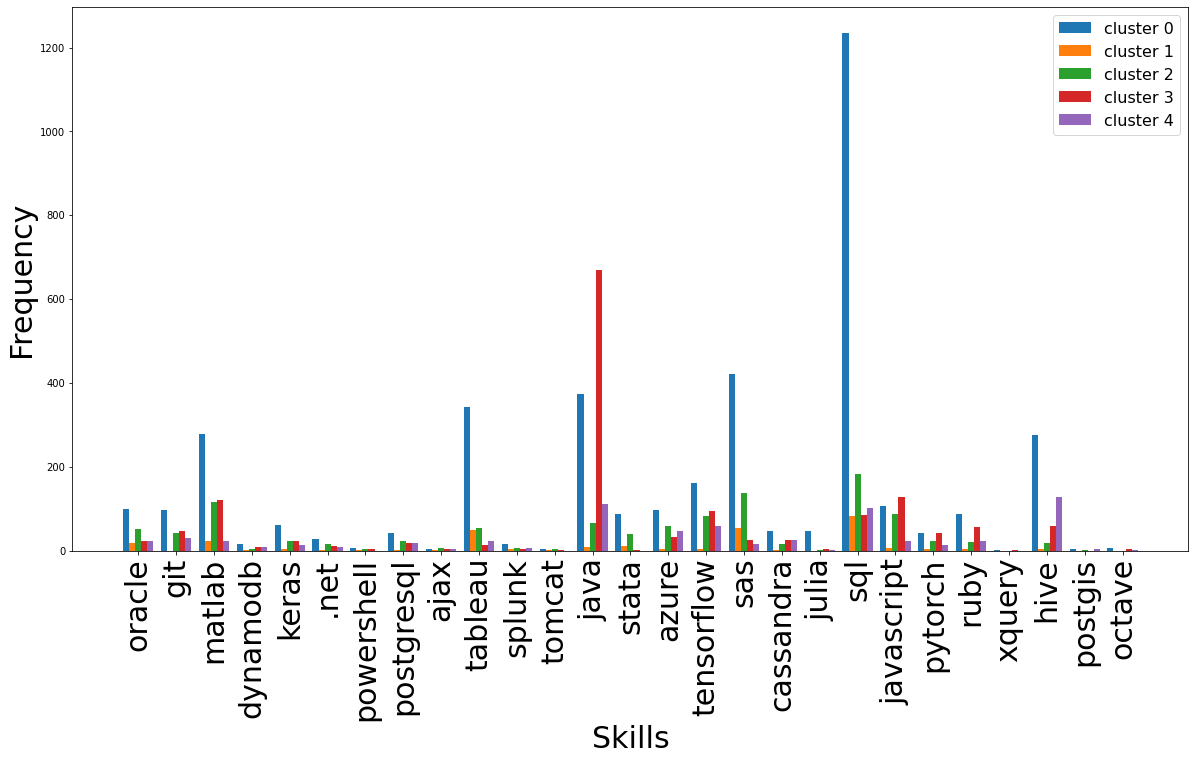

In [ ]:
# Frequencies of the skills separated by clusters
cluster_freq_skills = []
for i in range(0, 5):
  cluster_freq_skills.append(skills_df[list(skills)][huang_clusters_vis == i].sum().values)

n_skills = 27

plt.figure(figsize=(20, 10))
plt.xlabel('Skills', fontsize=30)
plt.ylabel('Frequency', fontsize=30)

def subbarchart(X, vals, width):
  n = len(vals)
  _X = np.arange(len(X))
  for i in range(n):
      plt.bar(_X - width/2. + i / float(n) * width, vals[i], width=width / float(n), align="edge", label='cluster %d' % i)   
  plt.xticks(_X, X, rotation='vertical', fontsize=30)
  plt.legend(fontsize=16)

c_n_skills = []
for c in cluster_freq_skills:
  c_n_skills.append(c[:n_skills])

subbarchart(list(skills)[:n_skills], c_n_skills, 0.8)
plt.show();

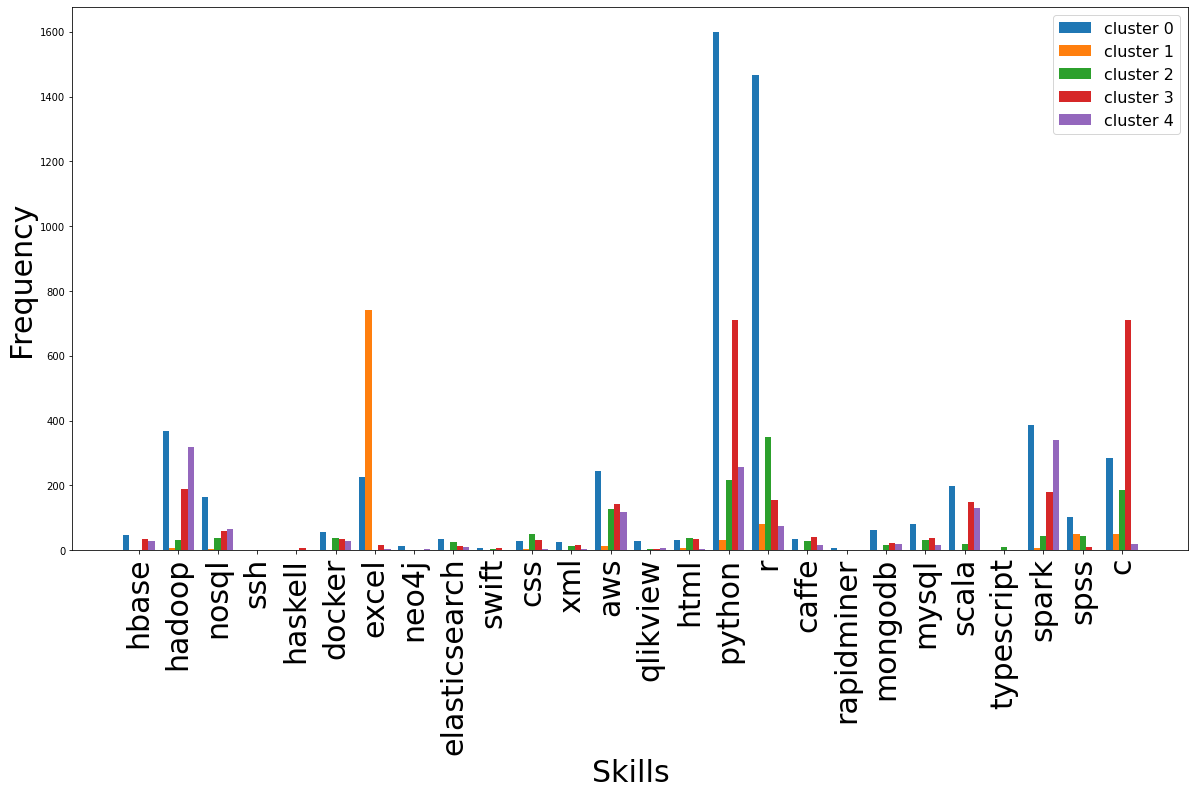

In [ ]:
# Frequencies of the skills separated by clusters continued
c_n_skills = []
for c in cluster_freq_skills:
  c_n_skills.append(c[n_skills:])

plt.figure(figsize=(20, 10))
plt.xlabel('Skills', fontsize=30)
plt.ylabel('Frequency', fontsize=30)

subbarchart(list(skills)[n_skills:], c_n_skills, 0.8)
plt.show();

# **Selection of Job Titles**

In [84]:
# Get data with cluster assignments 
skills_df['class']=list(huang_clusters_vis)
skills_df.shape

(4858, 57)

In [53]:
# Add titles to dataframe
skills_df['tokenized_title_join']=position_df['tokenized_title_join']
skills_df.shape

(4858, 57)

In [54]:
# For each cluster, break titles into noun chunks and identify the most common ones
for i in range(5):
  df_class = pd.DataFrame()
  df_class=skills_df[skills_df['class']==i]
  print('cluster',i,df_class.shape)
  all_titles=[]
  for sentence in df_class['tokenized_title_join']:
    sentence_doc = nlp(sentence)

    for chunk in sentence_doc.noun_chunks:
      all_titles.append(chunk)
  title_df = pd.DataFrame()
  title_df['title'] = all_titles
  title_df['title_join'] = [' '.join(map(str, l)) for l in title_df['title']]
  print(title_df['title_join'].value_counts().head())
  print()

cluster 0 (1373, 57)
Data Scientist               69
Sr                           57
Machine Learning             20
Machine Learning Engineer    18
Manager                      18
Name: title_join, dtype: int64

cluster 1 (1646, 57)
Data Scientist           298
Senior Data Scientist     79
Sr                        66
Data Engineer             29
Data Science              23
Name: title_join, dtype: int64

cluster 2 (396, 57)
Data Scientist               63
Data Engineer                30
Sr                           24
Senior Data Scientist        21
Machine Learning Engineer    17
Name: title_join, dtype: int64

cluster 3 (742, 57)
Research Analyst       30
Sr                     21
Scientist              16
Associate Scientist    11
Data Scientist         10
Name: title_join, dtype: int64

cluster 4 (701, 57)
Software Engineer                40
Sr                               36
Data Scientist                   27
Software Development Engineer    25
Machine Learning               

In [ ]:
df_original['position'].value_counts()

Data Scientist                                                351
Senior Data Scientist                                          96
Research Analyst                                               64
Data Engineer                                                  60
Machine Learning Engineer                                      56
                                                             ... 
AWS Americas Business Analytics & Sales Insights Leader         1
Genomic Data Scientist                                          1
Technical Lead                                                  1
Machine Learning Researcher - Audio/Speech/Computer Vision      1
Sr./Research Associate, Delivery Innovation                     1
Name: position, Length: 5242, dtype: int64